In [1]:
from ebaysdk.finding import Connection
import pandas as pd
from datetime import datetime, timedelta

api = Connection(config_file = 'ebay.yaml')

class APIError(Exception):
    """An API Error Exception"""

    def __init__(self, response):
        self.response = response

    def __str__(self):
        return "APIError: error = {}".format(self.response.dict()['errorMessage']['error']['message'])


def api2df(from_time, to_time):
        api_request = {
        # 16231 - saxophones
        'categoryId': '16231',
        'keywords': 'sax',
        'outputSelector' : [
                        'SellerInfo',
                        'StoreInfo',
                ],
        'siteID' : 'EBAY-GB',
        'itemFilter' : [
                {'name':'LocatedIn', 'value':'GB'},
                {'name':'EndTimeFrom', 'value' : from_time},
                {'name':'EndTimeTo', 'value' :to_time},
                {'name':'HideDuplicateItems', 'value':'true'}
                ],
        'paginationInput': {
                'entriesPerPage': 100,
                'pageNumber': 1},
        'sortOrder' : 'EndTimeSoonest'
        }

        response = api.execute('findItemsByCategory', api_request)
        
        if response.dict()['ack'] == 'Failure':
                raise APIError(response)

        print(response.dict()['paginationOutput'])

        df = pd.io.json.json_normalize(response.dict()['searchResult']['item'],  sep='-')
        '''
        return df[['itemId', 'title', 'viewItemURL', 'postalCode','sellerInfo-sellerUserName',                                                        'shippingInfo-shippingServiceCost-_currencyId',
                'shippingInfo-shippingServiceCost-value', 'sellingStatus-currentPrice-_currencyId',
       'sellingStatus-currentPrice-value', 'listingInfo-bestOfferEnabled', 'listingInfo-buyItNowAvailable', 'listingInfo-startTime', 'listingInfo-endTime', 'listingInfo-watchCount','condition-conditionId', 'condition-conditionDisplayName'
       ]].set_index('itemId')
        '''
        return df.set_index('itemId')

from_time = datetime.now().isoformat()
to_time =  (datetime.now() + timedelta(days=1)).isoformat()

# df = api2df(from_time, to_time)

In [6]:
from ebaysdk.shopping import Connection as shopping
import numpy
 
shop_api = shopping(config_file = 'ebay.yaml')

# df.index.values[0]

specifics = ['Brand', 'Type', 'Skill Level', 'Body Finish', 'Body Material', 'Key Finish', 'Custom Bundle', 'Modified Item', 'Modified Description', 'Country/Region of Manufacture']

def nameValue2dict(nv):
    return {item['Name']:item['Value'] for item in nv}

def itemSpecificGetter(itemid):

    api_request = {
            # 16231 - saxophones
            'ItemID' : itemid,
            'IncludeSelector' : ['ItemSpecifics'],
            }

    response = shop_api.execute('GetSingleItem', api_request)

    if response.dict()['Ack'] == 'Failure':
        raise APIError(response)

    df1 = pd.io.json.json_normalize(response.dict()['Item'],  sep='-')

    if 'ItemSpecifics-NameValueList' in df1.columns:
        df1['ItemSpecifics'] = df1['ItemSpecifics-NameValueList'].apply(nameValue2dict)

        df1 = df1.drop('ItemSpecifics-NameValueList', axis=1)

        for s in specifics:
            if s in df1['ItemSpecifics'].loc[0]:
                df1['ItemSpecifics-{}'.format(s)] = df1['ItemSpecifics'].loc[0][s]
            else:
                df1['ItemSpecifics-{}'.format(s)] = np.nan
    
    else: 
         for s in specifics:           
            df1['ItemSpecifics-{}'.format(s)] = np.nan
    
    return df1

def itemSpecificGetter(itemid):

    api_request = {
            # 16231 - saxophones
            'ItemID' : itemid,
            'IncludeSelector' : ['ItemSpecifics'],
            }

    response = shop_api.execute('GetSingleItem', api_request)

    if response.dict()['Ack'] == 'Failure':
        raise APIError(response)

    df1 = pd.io.json.json_normalize(response.dict()['Item'],  sep='-')

    if 'ItemSpecifics-NameValueList' in df1.columns:
        df1['ItemSpecifics'] = df1['ItemSpecifics-NameValueList'].apply(nameValue2dict)

        df1 = df1.drop('ItemSpecifics-NameValueList', axis=1)

        for s in specifics:
            if s in df1['ItemSpecifics'].loc[0]:
                df1['ItemSpecifics-{}'.format(s)] = df1['ItemSpecifics'].loc[0][s]
            else:
                df1['ItemSpecifics-{}'.format(s)] = np.nan
    
    else: 
         for s in specifics:           
            df1['ItemSpecifics-{}'.format(s)] = np.nan
    
    return df1


def allItemSpecifics(itemIDs):
    return pd.concat([itemSpecificGetter(itemid) for itemid in itemIDs])

def getItemIds():
    yesterday = (datetime.now() - timedelta(days=1)).strftime("%m-%d-%Y")
    df = pd.read_csv('data/finding/{}.csv'.format(yesterday), index_col='itemId')
    itemIDs = df.index.values
    df1 = allItemSpecifics(itemIDs)
    df1.join(df).to_csv('data/shopping/{}.csv'.format(yesterday))    


itemSpecificGetter(224045256301)

,Description,ItemID,EndTime,ViewItemURLForNaturalSearch,ListingType,Location,GalleryURL,PictureURL,PrimaryCategoryID,PrimaryCategoryName,...,ItemSpecifics-Brand,ItemSpecifics-Type,ItemSpecifics-Skill Level,ItemSpecifics-Body Finish,ItemSpecifics-Body Material,ItemSpecifics-Key Finish,ItemSpecifics-Custom Bundle,ItemSpecifics-Modified Item,ItemSpecifics-Modified Description,ItemSpecifics-Country/Region of Manufacture
0,Thank you for visiting our ebay store! Note: -...,224045256301,2020-09-14T14:37:17.000Z,https://www.ebay.com/itm/ammoon-Mini-Pocket-Bb...,FixedPriceItem,London,https://thumbs2.ebaystatic.com/pict/2240452563...,[https://i.ebayimg.com/00/s/OTU2WDcxMA==/z/NcM...,16231,Musical Instruments:Wind & Woodwind:Band & Orc...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [215]:
df1.join(df[['postalCode', 'location']])

,EndTime,ViewItemURLForNaturalSearch,ListingType,Location,GalleryURL,PictureURL,PrimaryCategoryID,PrimaryCategoryName,BidCount,ListingStatus,...,ItemSpecifics-NameValueList-Value,ConditionDescription,GlobalShipping,BuyItNowAvailable,ConvertedBuyItNowPrice-_currencyID,ConvertedBuyItNowPrice-value,QuantityAvailableHint,QuantityThreshold,postalCode,location
ItemID,,,,,,,,,,,,,,,,,,,,,
253864995727,2020-07-11T23:50:33.000Z,https://www.ebay.com/itm/Protec-Bpstrap-Acolch...,FixedPriceItem,UK,https://thumbs4.ebaystatic.com/pict/2538649957...,[https://i.ebayimg.com/00/s/NTIwWDMxMg==/z/H7E...,16231,Instrumentos musicales:Instrumentos de viento ...,0,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United Kingdom
372433869443,2020-07-11T23:50:38.000Z,https://www.ebay.com/itm/Protec-Bpstrap-Rembou...,FixedPriceItem,UK,https://thumbs4.ebaystatic.com/pict/3724338694...,[https://i.ebayimg.com/00/s/NTIwWDMxMg==/z/H7E...,16231,Instruments de musique:Instruments à vent (Boi...,0,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United Kingdom
253864995782,2020-07-11T23:50:39.000Z,https://www.ebay.com/itm/Protec-Bpstrap-Imbott...,FixedPriceItem,UK,https://thumbs3.ebaystatic.com/pict/2538649957...,[https://i.ebayimg.com/00/s/NTIwWDMxMg==/z/H7E...,16231,Strumenti musicali:Strumenti a fiato: legni:Ba...,0,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United Kingdom
372433869465,2020-07-11T23:50:41.000Z,https://www.ebay.com/itm/Protec-Bpstrap-Gepols...,FixedPriceItem,UK,https://thumbs2.ebaystatic.com/pict/3724338694...,[https://i.ebayimg.com/00/s/NTIwWDMxMg==/z/H7E...,16231,Musikinstrumente:Blasinstrumente:Band & Orches...,0,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United Kingdom
114146766828,2020-07-12T03:28:30.000Z,https://www.ebay.com/itm/Lebayle-Studio-Tenor-...,FixedPriceItem,East Boldon,https://thumbs1.ebaystatic.com/pict/1141467668...,[https://i.ebayimg.com/00/s/MTYwMFg2ODY=/z/v5k...,16231,Musical Instruments:Wind & Woodwind:Band & Orc...,0,Active,...,Tenor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NE360PU,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203019795919,2020-07-12T20:26:04.000Z,https://www.ebay.com/itm/SAXRAX-Baritone-Saxop...,FixedPriceItem,"Kirkcaldy, Fife",https://thumbs4.ebaystatic.com/pict/2030197959...,[https://i.ebayimg.com/00/s/OTU4WDY0NA==/z/JAk...,16231,Musical Instruments:Wind & Woodwind:Band & Orc...,0,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KY25PN,United Kingdom
203019798088,2020-07-12T20:29:35.000Z,https://www.ebay.com/itm/SAXRAX-Curved-Soprano...,FixedPriceItem,"Kirkcaldy, Fife",https://thumbs1.ebaystatic.com/pict/2030197980...,[https://i.ebayimg.com/00/s/MTAyNFg4ODc=/z/uko...,16231,Musical Instruments:Wind & Woodwind:Band & Orc...,0,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KY25PN,United Kingdom
392863290256,2020-07-12T21:07:07.000Z,https://www.ebay.com/itm/Rico-Royal-Tenor-sax-...,Chinese,.,https://thumbs1.ebaystatic.com/pict/3928632902...,[https://i.ebayimg.com/00/s/MTIwMFgxNjAw/z/O1U...,16231,Musical Instruments:Wind & Woodwind:Band & Orc...,0,Active,...,NaN,NaN,true,NaN,NaN,NaN,NaN,NaN,NaN,United Kingdom


In [213]:
df1 = df1.set_index('ItemID')

In [9]:
import pandas as pd
specifics = pd.read_csv('SaxophoneSpecifics.csv', delimiter = '\t', error_bad_lines=False).groupby('Name')['Value'].unique()
specifics

b'Skipping line 125: expected 10 fields, saw 12\nSkipping line 128: expected 10 fields, saw 12\n'


Name
Body Finish                      [Amber Lacquer, Black Lacquer, Black Nickel-Pl...
Body Material                    [Brass, Copper, Nickel Silber, Red Brass, Silv...
Brand                            [Unbranded, Adler, Alexander, Altus, Amati, Ar...
Country/Region of Manufacture    [Unknown, Afghanistan, Albania, Algeria, Ameri...
Custom Bundle                                                            [No, Yes]
Key Finish                       [Brass, Gold Lacquered, Silver-Plated, Unlacqu...
MPN                                                               [Does Not Apply]
Modified Item                                                            [No, Yes]
Skill Level                       [Beginner, Intermediate, Professional, Children]
Type                                         [Alto, Baritone/Bass, Soprano, Tenor]
Name: Value, dtype: object

In [168]:
df.head()

,title,viewItemURL,postalCode,sellerInfo-sellerUserName,shippingInfo-shippingServiceCost-_currencyId,shippingInfo-shippingServiceCost-value,sellingStatus-currentPrice-_currencyId,sellingStatus-currentPrice-value,listingInfo-bestOfferEnabled,listingInfo-buyItNowAvailable,listingInfo-startTime,listingInfo-endTime,listingInfo-watchCount,condition-conditionId,condition-conditionDisplayName
itemId,,,,,,,,,,,,,,,
392722209060,weltklang alto saxophone soloist,https://www.ebay.com/itm/weltklang-alto-saxoph...,SL37QU,fantasticdeals3,USD,80.95,GBP,395.0,false,false,2020-03-10T20:27:38.000Z,2020-07-10T20:27:38.000Z,2,3000,Used
303615307035,Vintage Baritone Saxophone.,https://www.ebay.com/itm/Vintage-Baritone-Saxo...,LS212BE,6688chrisc,NaN,NaN,GBP,595.0,true,false,2020-07-05T20:42:53.000Z,2020-07-10T20:42:53.000Z,13,3000,Used
193202614928,REIG Pocoyo Musical Carpet,https://www.ebay.com/itm/REIG-Pocoyo-Musical-C...,NaN,thepomshop,USD,6.95,AUD,63.32,false,false,2019-11-10T20:52:39.000Z,2020-07-10T20:52:39.000Z,NaN,1000,New
203018057769,AirCell Suspension Saxophone Neck Strap,https://www.ebay.com/itm/AirCell-Suspension-Sa...,KY25PN,liquid-silicon,NaN,NaN,GBP,19.95,false,false,2020-06-10T21:13:16.000Z,2020-07-10T21:13:16.000Z,NaN,1000,New
372800823491,Wood Stone Original Alto Sax Ligature (Selmer ...,https://www.ebay.com/itm/Wood-Stone-Original-A...,SL68BT,windcraft-ltd,USD,12.49,GBP,145.04,false,false,2019-10-10T21:23:33.000Z,2020-07-10T21:23:33.000Z,1,1000,New


In [145]:
import numpy as np

def nameValue2dict(nv):
    return {item['Name']:item['Value'] for item in nv}




Index(['ItemID', 'EndTime', 'ViewItemURLForNaturalSearch', 'ListingType',
       'Location', 'GalleryURL', 'PictureURL', 'PrimaryCategoryID',
       'PrimaryCategoryName', 'BidCount', 'ListingStatus', 'TimeLeft', 'Title',
       'Country', 'AutoPay', 'ConditionID', 'ConditionDisplayName',
       'GlobalShipping', 'ConvertedCurrentPrice-_currencyID',
       'ConvertedCurrentPrice-value', 'ItemSpecifics', 'ItemSpecifics-Brand',
       'ItemSpecifics-Type', 'ItemSpecifics-Skill Level',
       'ItemSpecifics-Body Finish', 'ItemSpecifics-Body Material',
       'ItemSpecifics-Key Finish', 'ItemSpecifics-Custom Bundle',
       'ItemSpecifics-Modified Item', 'ItemSpecifics-Modified Description',
       'ItemSpecifics-Country/Region of Manufacture'],
      dtype='object')

In [147]:
df1

,ItemID,EndTime,ViewItemURLForNaturalSearch,ListingType,Location,GalleryURL,PictureURL,PrimaryCategoryID,PrimaryCategoryName,BidCount,...,ItemSpecifics-Brand,ItemSpecifics-Type,ItemSpecifics-Skill Level,ItemSpecifics-Body Finish,ItemSpecifics-Body Material,ItemSpecifics-Key Finish,ItemSpecifics-Custom Bundle,ItemSpecifics-Modified Item,ItemSpecifics-Modified Description,ItemSpecifics-Country/Region of Manufacture
0,392722209060,2020-08-10T20:27:38.000Z,https://www.ebay.com/itm/weltklang-alto-saxoph...,FixedPriceItem,Slough,https://thumbs1.ebaystatic.com/pict/3927222090...,[https://i.ebayimg.com/00/s/MTIwMFgxNjAw/z/2ak...,16231,Musical Instruments:Wind & Woodwind:Band & Orc...,0,...,Weltklang,Alto,all,Gold Lacquer,NaN,NaN,NaN,NaN,NaN,NaN


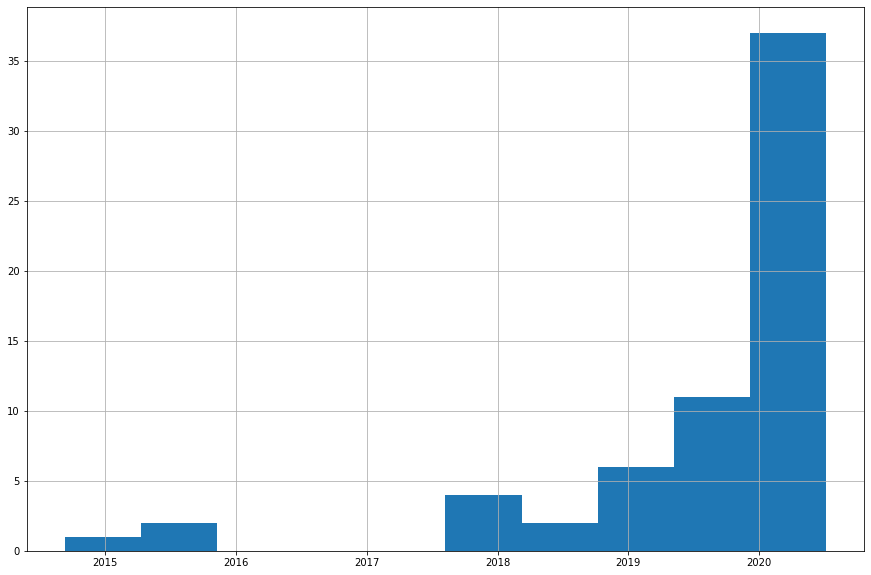

In [61]:
#df[['listingInfo-startTime', 'listingInfo-endTime']]
plt.figure(figsize=(15,10))
pd.to_datetime(df['listingInfo-startTime']).hist()

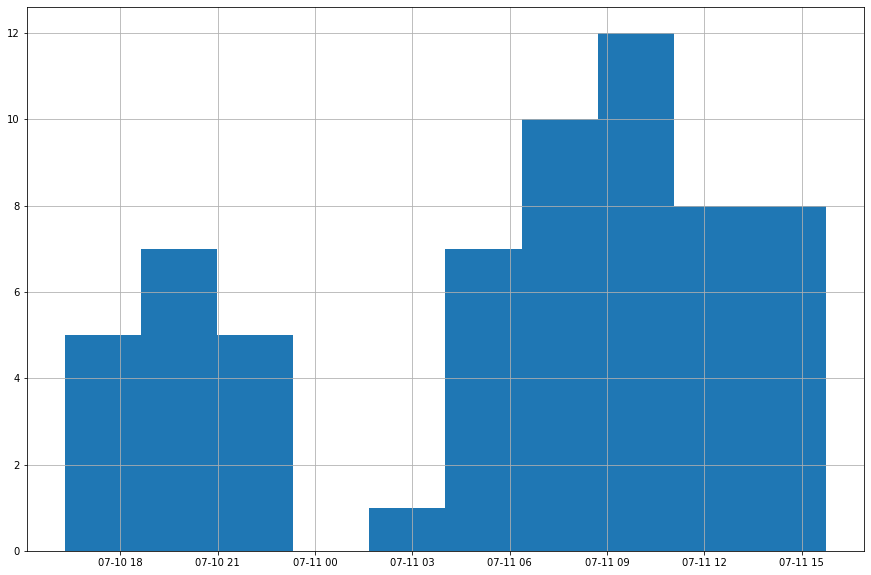

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
pd.to_datetime(df['listingInfo-endTime']).hist()

In [76]:
response1.dict()

{'Timestamp': '2020-07-07T23:50:26.988Z',
 'Ack': 'Success',
 'Build': 'E1141_CORE_APILW_19170841_R1',
 'Version': '1141',
 'Item': {'ItemID': '133453040314',
  'EndTime': '2020-07-30T20:32:22.000Z',
  'ViewItemURLForNaturalSearch': 'https://www.ebay.com/itm/NEW-Soprano-Saxophone-FREE-Shipping-inside-continental-US-/133453040314',
  'ListingType': 'FixedPriceItem',
  'Location': 'Tipton, Missouri',
  'GalleryURL': 'https://thumbs3.ebaystatic.com/pict/1334530403148080_1.jpg',
  'PictureURL': ['https://i.ebayimg.com/00/s/MTYwMFgyODk=/z/O94AAOSw8-5e-5up/$_57.JPG?set_id=8800005007',
   'https://i.ebayimg.com/00/s/MzAwWDQwMA==/z/xIAAAOSww3Ze-5u0/$_57.JPG?set_id=8800005007',
   'https://i.ebayimg.com/00/s/MTIwMFgxNjAw/z/jpYAAOSwmQNe-5vA/$_57.JPG?set_id=8800005007'],
  'PrimaryCategoryID': '16231',
  'PrimaryCategoryName': 'Musical Instruments & Gear:Wind & Woodwind:Band & Orchestral:Saxophones',
  'BidCount': '0',
  'ConvertedCurrentPrice': {'_currencyID': 'USD', 'value': '100.0'},
  'Listin

In [204]:
datetime.now().strftime("%m-%d-%Y")

'07-14-2020'

In [72]:
response.dict()['paginationOutput']

{'pageNumber': '1',
 'entriesPerPage': '10',
 'totalPages': '476',
 'totalEntries': '4752'}

In [73]:
df = pd.io.json.json_normalize(response.dict()['searchResult']['item'],  sep='-')


Index(['itemId', 'title', 'globalId', 'galleryURL', 'viewItemURL',
       'paymentMethod', 'autoPay', 'postalCode', 'location', 'country',
       'returnsAccepted', 'isMultiVariationListing', 'topRatedListing',
       'primaryCategory-categoryId', 'primaryCategory-categoryName',
       'storeInfo-storeName', 'storeInfo-storeURL',
       'sellerInfo-sellerUserName', 'sellerInfo-feedbackScore',
       'sellerInfo-positiveFeedbackPercent', 'sellerInfo-feedbackRatingStar',
       'sellerInfo-topRatedSeller',
       'shippingInfo-shippingServiceCost-_currencyId',
       'shippingInfo-shippingServiceCost-value', 'shippingInfo-shippingType',
       'shippingInfo-shipToLocations', 'shippingInfo-expeditedShipping',
       'shippingInfo-oneDayShippingAvailable', 'shippingInfo-handlingTime',
       'sellingStatus-currentPrice-_currencyId',
       'sellingStatus-currentPrice-value',
       'sellingStatus-convertedCurrentPrice-_currencyId',
       'sellingStatus-convertedCurrentPrice-value', 'selli

In [75]:
df[['itemId', 'title', 'viewItemURL', 'postalCode','sellerInfo-sellerUserName', 'shippingInfo-shippingServiceCost-_currencyId',
       'shippingInfo-shippingServiceCost-value', 'sellingStatus-currentPrice-_currencyId',
       'sellingStatus-currentPrice-value', 'listingInfo-bestOfferEnabled', 'listingInfo-buyItNowAvailable', 'listingInfo-startTime', 'listingInfo-endTime', 'listingInfo-watchCount','condition-conditionId', 'condition-conditionDisplayName']].set_index('itemId')

,title,viewItemURL,postalCode,sellerInfo-sellerUserName,shippingInfo-shippingServiceCost-_currencyId,shippingInfo-shippingServiceCost-value,sellingStatus-currentPrice-_currencyId,sellingStatus-currentPrice-value,listingInfo-bestOfferEnabled,listingInfo-buyItNowAvailable,listingInfo-startTime,listingInfo-endTime,listingInfo-watchCount,condition-conditionId,condition-conditionDisplayName
itemId,,,,,,,,,,,,,,,
233642929384,King Tempo Baritone Saxophone w/ Gig Bag,https://www.ebay.com/itm/King-Tempo-Baritone-S...,333**,mae-music,USD,50.0,USD,500.0,false,true,2020-07-07T18:19:21.000Z,2020-07-14T18:19:21.000Z,9,3000,Used
133453040314,NEW Soprano Saxophone *FREE Shipping* inside t...,https://www.ebay.com/itm/NEW-Soprano-Saxophone...,650**,scottbabs,USD,0.0,USD,100.0,false,false,2020-06-30T20:32:22.000Z,2020-07-30T20:32:22.000Z,55,1000,New
283938622116,Conn Virtuoso Deluxe Alto Gold Plate Full Pear...,https://www.ebay.com/itm/Conn-Virtuoso-Deluxe-...,871**,zapatista,USD,89.0,USD,3997.0,true,false,2020-07-06T00:55:50.000Z,2020-08-06T00:55:50.000Z,10,3000,Used
174340600156,Conn Naked Lady Alto Saxophone 6M Serial Numbe...,https://www.ebay.com/itm/Conn-Naked-Lady-Alto-...,323**,puppe_4442,USD,40.0,USD,1000.0,true,false,2020-07-07T01:06:46.000Z,2020-08-07T01:06:46.000Z,3,3000,Used
383620988614,Vintage Conn C melody Sax 1921,https://www.ebay.com/itm/Vintage-Conn-C-melody...,625**,miwea-55,USD,50.0,USD,300.0,true,false,2020-07-07T06:11:04.000Z,2020-08-07T06:11:04.000Z,3,3000,Used
264781382394,Vintage Rare LeBlanc System Vito Stencil Alto ...,https://www.ebay.com/itm/Vintage-Rare-LeBlanc-...,431**,junkdude-com,USD,65.0,USD,495.0,false,false,2020-07-01T02:34:42.000Z,2020-07-08T02:34:42.000Z,15,3000,Used
264782422788,CANNONBALL BIG BELL STONE SERIES ALTO SAXOPHON...,https://www.ebay.com/itm/CANNONBALL-BIG-BELL-S...,338**,jlovesyolie,USD,55.0,USD,1500.0,false,false,2020-07-02T01:07:57.000Z,2020-08-02T01:07:57.000Z,17,2500,Seller refurbished
333647681824,Yamaha YTS-200AD Advantage Tenor Saxophone Use...,https://www.ebay.com/itm/Yamaha-YTS-200AD-Adva...,333**,mae-music,USD,50.0,USD,157.5,false,false,2020-07-07T15:26:17.000Z,2020-07-14T15:26:17.000Z,11,3000,Used
193545530788,YAMAHA YAS-23 SAXOPHONE (FE3036256),https://www.ebay.com/itm/YAMAHA-YAS-23-SAXOPHO...,543**,stdauctions,USD,25.0,USD,270.0,false,false,2020-07-01T02:03:31.000Z,2020-07-08T02:03:31.000Z,21,3000,Used


In [15]:
from ebaysdk.shopping import Connection as Shopping

api_shop = Shopping(config_file = 'ebay.yaml')

def getItemSpecifics(ItemID):
    api_request = {
    'ItemID': ItemID,
    'IncludeSelector' : 'ItemSpecifics'}
    response = api_shop.execute('GetSingleItem', api_request)
    return {item['Name'] : item['Value'] for item in response1.dict()['Item']['ItemSpecifics']['NameValueList']}


{'Modified Item': 'No',
 'Country/Region of Manufacture': 'China',
 'Custom Bundle': 'No',
 'Body Finish': 'Gold Lacquer',
 'Type': 'Soprano',
 'MPN': 'Does Not Apply',
 'Key Finish': 'Gold Lacquered',
 'Body Material': 'Brass',
 'Brand': 'Simba Instruments',
 'Skill Level': 'Beginner',
 'UPC': 'Does not apply'}

In [5]:
import pandas as pd
pd.read_csv('data/finding/07-13-2020.csv', index_col=0)

,postalCode,location
itemId,,
224045256301,E177BP,United Kingdom
233619110578,IG75NR,United Kingdom
372335300286,SL68BT,United Kingdom
203021295012,KY25PN,United Kingdom
203021297049,KY25PN,United Kingdom
352971447647,N79**,United Kingdom
203021299863,KY25PN,United Kingdom
254512375746,SL68BT,United Kingdom
372953068997,SL68BT,United Kingdom


In [13]:
import boto3
import pandas as pd
import io
from datetime import datetime, timedelta

s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')

# bucket = s3.Bucket('ebayfindingdata')
yesterday = (datetime.now() - timedelta(days=1)).strftime("%m-%d-%Y")

obj = s3_client.get_object(Bucket = 'ebayfindingdata', Key = 'finding/{}.csv'.format(yesterday))

df = pd.read_csv(obj['Body'], index_col='itemId')

In [29]:
from ebaysdk.shopping import Connection as shopping
import pandas as pd 
import numpy as np

def nameValue2dict(nv):
    return {item['Name']:item['Value'] for item in nv}


 
shop_api = shopping(config_file = 'ebay.yaml')

specifics = ['Brand', 'Type', 'Skill Level', 'Body Finish', 'Body Material', 'Key Finish', 'Custom Bundle', 'Modified Item', 'Modified Description', 'Country/Region of Manufacture']


def itemSpecificGetter(itemid):

    api_request = {
            # 16231 - saxophones
            'ItemID' : itemid,
            #'IncludeSelector' : ['ItemSpecifics'],
            }

    response = shop_api.execute('GetAllBidders', api_request)

    if response.dict()['Ack'] == 'Failure':
        raise APIError(response)

    df1 = pd.io.json.json_normalize(response.dict()['Item'],  sep='-')

    if 'ItemSpecifics-NameValueList' in df1.columns:
        df1['ItemSpecifics'] = df1['ItemSpecifics-NameValueList'].apply(nameValue2dict)

        df1 = df1.drop('ItemSpecifics-NameValueList', axis=1)

        for s in specifics:
            if s in df1['ItemSpecifics'].loc[0]:
                df1['ItemSpecifics-{}'.format(s)] = df1['ItemSpecifics'].loc[0][s]
            else:
                df1['ItemSpecifics-{}'.format(s)] = np.nan
    
    else: 
         for s in specifics:           
            df1['ItemSpecifics-{}'.format(s)] = np.nan
    
    return df1


def allItemSpecifics(itemIDs):
    return pd.concat([itemSpecificGetter(itemid) for itemid in itemIDs])

def getItemIds():
    yesterday = (datetime.now() - timedelta(days=1)).strftime("%m-%d-%Y")
    df = pd.read_csv('data/finding/{}.csv'.format(yesterday), index_col='itemId')
    itemIDs = df.index.values
    df1 = allItemSpecifics(itemIDs)
    df1.join(df).to_csv('data/shopping/{}.csv'.format(yesterday))    


itemSpecificGetter(303639749069)

AttributeError: 'ResponseDataObject' object has no attribute 'Ack'

In [23]:
from ebaysdk.shopping import Connection as shopping
import pandas as pd 
import numpy as np

def nameValue2dict(nv):
    return {item['Name']:item['Value'] for item in nv}


 
shop_api = shopping(config_file = 'ebay.yaml')

specifics = ['Brand', 'Type', 'Skill Level', 'Body Finish', 'Body Material', 'Key Finish', 'Custom Bundle', 'Modified Item', 'Modified Description', 'Country/Region of Manufacture']


def itemSpecificGetter(itemid):

    api_request = {
            # 16231 - saxophones
            'ItemID' : itemid,
            'IncludeSelector' : ['Details, TextDescription'],
            }

    response = shop_api.execute('GetSingleItem', api_request)

    if response.dict()['Ack'] == 'Failure':
        raise APIError(response)

    df1 = pd.io.json.json_normalize(response.dict()['Item'],  sep='-')

    if 'ItemSpecifics-NameValueList' in df1.columns:
        df1['ItemSpecifics'] = df1['ItemSpecifics-NameValueList'].apply(nameValue2dict)

        df1 = df1.drop('ItemSpecifics-NameValueList', axis=1)

        for s in specifics:
            if s in df1['ItemSpecifics'].loc[0]:
                df1['ItemSpecifics-{}'.format(s)] = df1['ItemSpecifics'].loc[0][s]
            else:
                df1['ItemSpecifics-{}'.format(s)] = np.nan
    
    else: 
         for s in specifics:           
            df1['ItemSpecifics-{}'.format(s)] = np.nan
    
    return df1


def allItemSpecifics(itemIDs):
    return pd.concat([itemSpecificGetter(itemid) for itemid in itemIDs])

def getItemIds():
    yesterday = (datetime.now() - timedelta(days=1)).strftime("%m-%d-%Y")
    df = pd.read_csv('data/finding/{}.csv'.format(yesterday), index_col='itemId')
    itemIDs = df.index.values
    df1 = allItemSpecifics(itemIDs)
    df1.join(df).to_csv('data/shopping/{}.csv'.format(yesterday))    


df = itemSpecificGetter(303635927434)

s3.Object(bucket_name='ebayfindingdata', key='images/08-03-2020/303116830074/0.png')

In [23]:

keys[0][9:-4]

'08-03-2020'

In [38]:
from findDescription import ItemDescriptionFinder
import boto3

s3 = boto3.client('s3')
s3.list_objects(Bucket = 'ebayfindingdata', Prefix = 'finding/')
finding_keys = [o['Key'][8:-4] for o in s3.list_objects(Bucket = 'ebayfindingdata', Prefix = 'finding')['Contents'] if '.csv' in o['Key']]
shopping_keys = [o['Key'][9:-4] for o in s3.list_objects(Bucket = 'ebayfindingdata', Prefix = 'shopping')['Contents'] if '.csv' in o['Key']]
description_keys = [o['Key'][13:-4] for o in s3.list_objects(Bucket = 'ebayfindingdata', Prefix = 'description')['Contents'] if '.csv' in o['Key']]
missing_keys = [x for x in finding_keys if x not in description_keys]
print(missing_keys)
for k in missing_keys:
    idf = ItemDescriptionFinder()
    idf.findItemDescriptions(yesterday=k)

['08-12-2020', '08-13-2020', '08-14-2020', '08-15-2020', '08-16-2020', '08-21-2020', '08-22-2020', '08-23-2020', '08-24-2020', '08-25-2020']


In [40]:
s3 = boto3.client('s3')
s3.list_objects(Bucket = 'ebayfindingdata', Prefix = 'finding/')
description_keys = [o['Key'] for o in s3.list_objects(Bucket = 'ebayfindingdata', Prefix = 'description')['Contents'] if '.csv' in o['Key']]
description_keys

['descriptions/07-13-2020.csv',
 'descriptions/07-14-2020.csv',
 'descriptions/07-20-2020.csv',
 'descriptions/08-03-2020.csv',
 'descriptions/08-04-2020.csv',
 'descriptions/08-05-2020.csv',
 'descriptions/08-06-2020.csv',
 'descriptions/08-07-2020.csv',
 'descriptions/08-08-2020.csv',
 'descriptions/08-09-2020.csv',
 'descriptions/08-10-2020.csv',
 'descriptions/08-11-2020.csv',
 'descriptions/08-12-2020.csv',
 'descriptions/08-13-2020.csv',
 'descriptions/08-14-2020.csv',
 'descriptions/08-15-2020.csv',
 'descriptions/08-16-2020.csv',
 'descriptions/08-17-2020.csv',
 'descriptions/08-18-2020.csv',
 'descriptions/08-19-2020.csv',
 'descriptions/08-20-2020.csv',
 'descriptions/08-21-2020.csv',
 'descriptions/08-22-2020.csv',
 'descriptions/08-23-2020.csv',
 'descriptions/08-24-2020.csv',
 'descriptions/08-25-2020.csv']

In [48]:

s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')
keys = [o['Key'] for o in s3.list_objects(Bucket = 'ebayfindingdata', Prefix = 'shopping')['Contents'] if '.csv' in o['Key']]

df = pd.concat([pd.read_csv(s3.get_object(Bucket = 'ebayfindingdata', Key = k)['Body'], index_col=0) for k in keys])
df.index

Int64Index([303116830074, 303635927434, 254668152053, 233663229380,
            233663229383, 392623299136, 153994291511, 392328267364,
            283699087200, 153994319841,
            ...
            264570114837, 313163269388, 313163284405, 254457266785,
            254457251701, 324117881996, 263407979103, 182506399409,
            262874041789, 143690149638],
           dtype='int64', name='ItemID', length=5017)

In [47]:
df = df[~df['ItemID'].duplicated()]
df['ItemID'].values

array([303116830074, 303635927434, 254668152053, ..., 182506399409,
       262874041789, 143690149638])